In [1]:
!pip install torch torchvision pytorch-lightning matplotlib pillow

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report



In [3]:
# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configuration
DATA_DIR = r"C:\Users\dell\Downloads\archive (1)\train"  # <- Change this
BATCH_SIZE = 32
EPOCHS = 10
IMG_SIZE = 224
LR = 1e-4



Using device: cpu


In [4]:
# Data transformations
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])



In [5]:
# Load dataset
full_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transform)
num_classes = len(full_dataset.classes)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transform  # Use val transforms

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)





In [6]:
# Model setup
model = models.resnet50(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [7]:
# Training loop
def train():
    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {total_loss:.4f}")
        validate()




In [8]:
# Validation
def validate():
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu()
            all_preds.extend(preds)
            all_labels.extend(labels)

    print("Validation Report:")
    print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))



In [9]:
from tqdm import tqdm  # Add at the top

EPOCHS = 3  # Reduced to 3 for quicker training and testing

# Training loop with progress bar
def train():
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix(loss=running_loss / (len(progress_bar) + 1e-8))

        print(f"Epoch [{epoch+1}] complete. Avg Loss: {running_loss / len(train_loader):.4f}")
        validate()

# Run training
if __name__ == "__main__":
    train()
    torch.save(model.state_dict(), "resnet50_vehicle_model.pth")
    print("Model saved as resnet50_vehicle_model.pth")


Epoch 1/3: 100%|███████████████████████████████████████████████████████████| 35/35 [04:22<00:00,  7.49s/it, loss=0.905]


Epoch [1] complete. Avg Loss: 0.9049
Validation Report:
              precision    recall  f1-score   support

         SUV       0.90      0.78      0.84        36
         bus       1.00      1.00      1.00        30
family sedan       0.74      0.74      0.74        23
 fire engine       1.00      0.90      0.95        29
 heavy truck       0.89      0.96      0.93        26
        jeep       1.00      1.00      1.00        29
     minibus       1.00      0.87      0.93        30
  racing car       0.93      1.00      0.97        28
        taxi       0.80      0.95      0.87        21
       truck       0.88      1.00      0.93        28

    accuracy                           0.92       280
   macro avg       0.91      0.92      0.91       280
weighted avg       0.92      0.92      0.92       280



Epoch 2/3: 100%|███████████████████████████████████████████████████████████| 35/35 [04:22<00:00,  7.49s/it, loss=0.106]


Epoch [2] complete. Avg Loss: 0.1056
Validation Report:
              precision    recall  f1-score   support

         SUV       0.97      0.92      0.94        36
         bus       1.00      1.00      1.00        30
family sedan       0.81      0.96      0.88        23
 fire engine       1.00      0.97      0.98        29
 heavy truck       0.96      0.96      0.96        26
        jeep       1.00      0.97      0.98        29
     minibus       1.00      0.93      0.97        30
  racing car       0.97      1.00      0.98        28
        taxi       0.95      0.95      0.95        21
       truck       0.97      1.00      0.98        28

    accuracy                           0.96       280
   macro avg       0.96      0.97      0.96       280
weighted avg       0.97      0.96      0.96       280



Epoch 3/3: 100%|██████████████████████████████████████████████████████████| 35/35 [04:21<00:00,  7.46s/it, loss=0.0295]


Epoch [3] complete. Avg Loss: 0.0295
Validation Report:
              precision    recall  f1-score   support

         SUV       0.97      0.86      0.91        36
         bus       1.00      1.00      1.00        30
family sedan       0.73      0.96      0.83        23
 fire engine       1.00      0.97      0.98        29
 heavy truck       0.96      0.96      0.96        26
        jeep       1.00      1.00      1.00        29
     minibus       0.97      0.93      0.95        30
  racing car       0.97      1.00      0.98        28
        taxi       1.00      0.90      0.95        21
       truck       0.96      0.96      0.96        28

    accuracy                           0.95       280
   macro avg       0.96      0.95      0.95       280
weighted avg       0.96      0.95      0.95       280

Model saved as resnet50_vehicle_model.pth


Trained Model Weights

In [19]:
import torch
from torchvision import models

# Load the model and weights
NUM_CLASSES = 10  # your number of classes
model = models.resnet50(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
model.load_state_dict(torch.load("resnet50_vehicle_model.pth", map_location='cpu'))  # adjust device if needed
model.eval()

# Display model weights info
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Layer: {name}")
        print(f"  Shape: {param.shape}")
        print(f"  Min: {param.min().item():.6f}")
        print(f"  Max: {param.max().item():.6f}")
        print(f"  Mean: {param.mean().item():.6f}")
        print("-" * 40)


Layer: conv1.weight
  Shape: torch.Size([64, 3, 7, 7])
  Min: -0.782192
  Max: 0.781259
  Mean: -0.000560
----------------------------------------
Layer: bn1.weight
  Shape: torch.Size([64])
  Min: 0.000000
  Max: 0.508317
  Mean: 0.257388
----------------------------------------
Layer: bn1.bias
  Shape: torch.Size([64])
  Min: -0.502357
  Max: 0.847264
  Mean: 0.210755
----------------------------------------
Layer: layer1.0.conv1.weight
  Shape: torch.Size([64, 64, 1, 1])
  Min: -0.726316
  Max: 0.389026
  Mean: -0.004503
----------------------------------------
Layer: layer1.0.bn1.weight
  Shape: torch.Size([64])
  Min: 0.000000
  Max: 0.375402
  Mean: 0.187828
----------------------------------------
Layer: layer1.0.bn1.bias
  Shape: torch.Size([64])
  Min: -0.278389
  Max: 0.528501
  Mean: 0.030917
----------------------------------------
Layer: layer1.0.conv2.weight
  Shape: torch.Size([64, 64, 3, 3])
  Min: -0.467285
  Max: 0.441910
  Mean: 0.000808
-----------------------------

Evaluation Metrices


In [20]:
import torch
from sklearn.metrics import precision_score, recall_score, average_precision_score
import numpy as np

def evaluate_metrics(model, dataloader, class_names):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Calculate Precision and Recall (macro average)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')

    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")

    # Calculate Average Precision (AP) per class for mAP
    # For this, we need binary indicator arrays for each class (one-vs-rest)
    n_classes = len(class_names)
    binary_labels = np.zeros((len(all_labels), n_classes))
    binary_labels[np.arange(len(all_labels)), all_labels] = 1

    average_precisions = []
    for i in range(n_classes):
        ap = average_precision_score(binary_labels[:, i], all_probs[:, i])
        average_precisions.append(ap)
        print(f"AP for class {class_names[i]}: {ap:.4f}")

    mAP = np.mean(average_precisions)
    print(f"\nmAP (mean Average Precision): {mAP:.4f}")


In [21]:
evaluate_metrics(model, val_loader, class_names)


Precision (macro): 0.9559
Recall (macro): 0.9547
AP for class SUV: 0.9739
AP for class bus: 1.0000
AP for class family sedan: 0.9140
AP for class fire engine: 0.9978
AP for class heavy truck: 0.9971
AP for class jeep: 1.0000
AP for class minibus: 0.9767
AP for class racing car: 1.0000
AP for class taxi: 0.9978
AP for class truck: 0.9934

mAP (mean Average Precision): 0.9851


Demo of model displaying predictions made

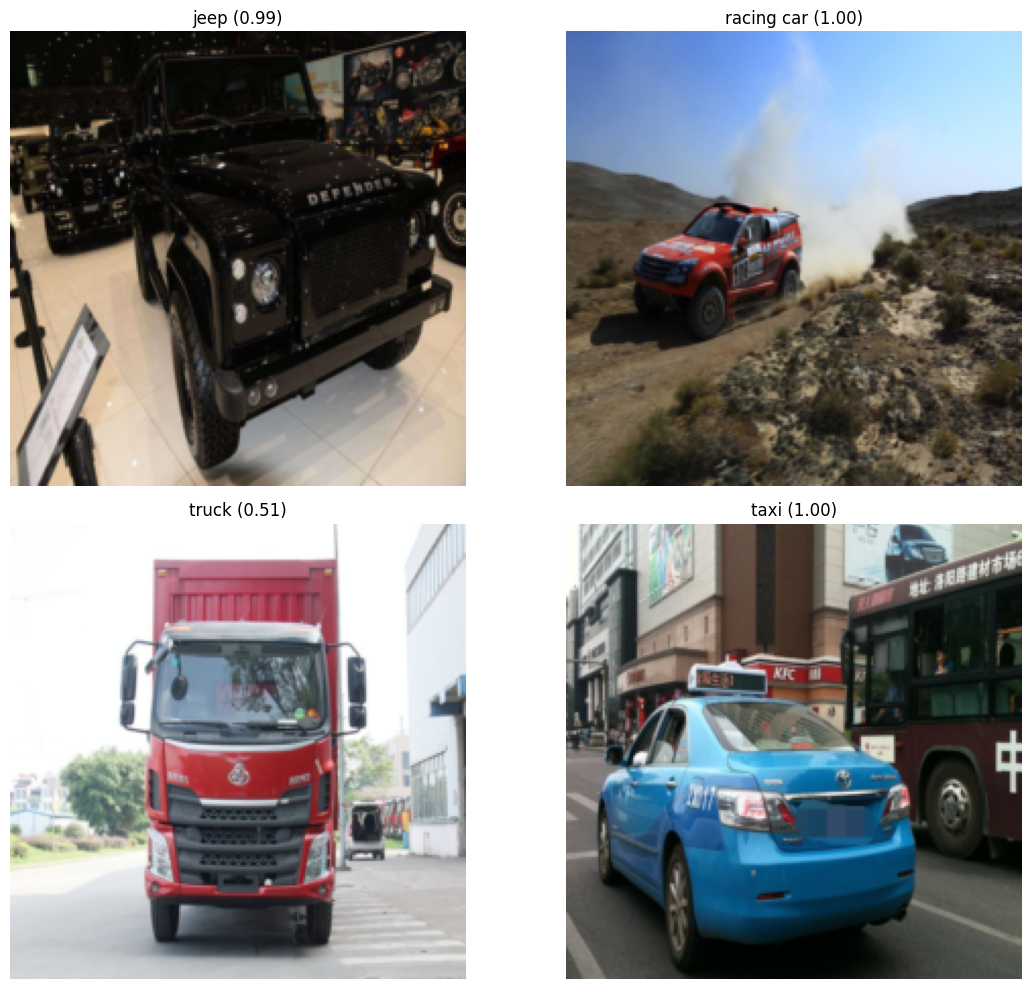

In [18]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set test folder path here
test_dir = r"C:\Users\dell\Downloads\archive (1)\test"  # Change this to your test images folder

# List image files (take only 4)
image_paths = [os.path.join(test_dir, f) for f in os.listdir(test_dir)
               if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:4]

# Define classes
class_names = [
    "SUV",
    "bus",
    "family sedan",
    "fire engine",
    "heavy truck",
    "jeep",
    "minibus",
    "racing car",
    "taxi",
    "truck"
]
NUM_CLASSES = len(class_names)

# Transform same as training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load model architecture and weights
model = models.resnet50(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
model.load_state_dict(torch.load("resnet50_vehicle_model.pth", map_location=device))
model.to(device)
model.eval()

def predict_and_prepare_image(image_path):
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.nn.functional.softmax(output, dim=1)[0]
        pred_idx = probs.argmax().item()
        pred_class = class_names[pred_idx]
        confidence = probs[pred_idx].item()

    # Prepare image for display (unnormalize)
    img_disp = np.transpose(img_tensor.squeeze(0).cpu().numpy(), (1, 2, 0))
    img_disp = img_disp * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img_disp = np.clip(img_disp, 0, 1)
    return img_disp, pred_class, confidence

# Plotting the 4 images in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

for i, path in enumerate(image_paths):
    img_disp, pred_class, confidence = predict_and_prepare_image(path)
    axs[i].imshow(img_disp)
    axs[i].set_title(f"{pred_class} ({confidence:.2f})")
    axs[i].axis("off")

# Hide any unused subplots if less than 4 images
for j in range(len(image_paths), 4):
    axs[j].axis("off")

plt.tight_layout()
plt.show()
